In [313]:
import numpy as np
import pandas as pd
import pickle
import os
import gdown
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib
import time

# Import Models and Datasets

In [314]:
# Should take about 4 minutes if files not already present
# Import pretrained models
path = "./"
m = "model_"
models = ["lr.sav", "rf.sav", "xgb.sav", "ffnn.keras", "cnn.keras"]
model_urls = [
    "https://drive.google.com/file/d/1cQfOEH3b6-dxVMkEL2aM8N5p5Zt9jNJw/view?usp=drive_link",
    "https://drive.google.com/file/d/1OqREa20mOlTnZVdsZ-_lKBfkwIl4fJYG/view?usp=drive_link",
    "https://drive.google.com/file/d/1Q4mzsXIL4bX8sXpG6mMpvjCmvXgT9eh2/view?usp=drive_link",
    "https://drive.google.com/file/d/1AV2IFpEU7EGn4ZOJWgmKdoq-ghxUaEjD/view?usp=drive_link",
    "https://drive.google.com/file/d/1Try-1FfpfbXPJGq94wm9ZuawaZHZIzuU/view?usp=drive_link",
]

# Import Incompleted studies to add to Dashboard DataFrame
groups = [
    "X_test.pkl",
    "X_test_pca.pkl",
    "y_test.pkl",
    "X_incompleted.pkl",
    "X_incompleted_pca.pkl",
    "y_incompleted.pkl",
]
group_urls = [
    "https://drive.google.com/file/d/1Ccbn6ddoh9XzqN1DTnakfEAN1yKJtTYq/view?usp=drive_link",
    "https://drive.google.com/file/d/1LmemYBiU6dir12dZYWPOpHj7JMYF8iLa/view?usp=drive_link",
    "https://drive.google.com/file/d/1MxuunA7hAh5RODKXGN11wFK4BzjV8rgw/view?usp=drive_link",
    "https://drive.google.com/file/d/1-EmGbMENBqMZwH9xxyNujwKnsDiVL3mD/view?usp=drive_link",
    "https://drive.google.com/file/d/1RQgpE9CgNhpJAKqIX5z_wi3yItRu7pCo/view?usp=drive_link",
    "https://drive.google.com/file/d/1Z3KF8b1ntL5quFkv71aGD0vF6DNM8S4Q/view?usp=drive_link",
]

for i, model in enumerate(models):
    if os.path.isfile(path + m + model):
        pass
    else:
        output = m + model

        gdown.download(model_urls[i], output, fuzzy=True)


for i, group in enumerate(groups):
    if os.path.isfile(path + group):
        pass
    else:
        output = group

        gdown.download(group_urls[i], output, fuzzy=True)

In [315]:
# import Dashboard DataFrame
if os.path.isfile("./study_info_df.csv"):
    pass
else:
    # Should only take ~30 seconds
    url = "https://drive.google.com/file/d/1sSYhHvWkYVRFoB1ulEblmTwo9iSibYpG/view?usp=drive_link"

    output = "study_info_df.csv"

    gdown.download(url, output, fuzzy=True)

study_info_df = pd.read_csv("./study_info_df.csv")
study_info_df

,nctId,status,phases,description,inclusion_criteria,exclusion_criteria,intervention_type,intervention_name,disease,outcome_measures,outcome_timeframes,durationMonths
0,NCT03202394,COMPLETED,['PHASE2'],"This is a randomized, double blind, placebo co...",Inclusion Criteria:\n\n1. Has provided (or rel...,:\n\n1. Age \< 18 years or \>75 years old\n2. ...,"['DRUG', 'DRUG']","['BIO-11006', 'Placebo']","['Respiratory Distress Syndrome, Adult']",['Incidence of treatment-emergent adverse even...,['28 days'],32.266667
1,NCT02138214,COMPLETED,['PHASE2'],PRIMARY OBJECTIVES:\n\nI. To determine the rat...,Inclusion Criteria:\n\n* Pre-operative diagnos...,:\n\n* Largest papillary thyroid carcinoma \< ...,"['PROCEDURE', 'PROCEDURE', 'OTHER']","['Thyroidectomy', 'entral lymph node dissectio...","['Stage I Papillary Thyroid Cancer', 'Stage II...",['Percentage of Participants With Transient Hy...,"['Post-operative day 1', 'At day 12', '2 weeks...",65.733333
2,NCT00976274,COMPLETED,['NA'],The details of study objective are followed by...,Inclusion Criteria:(three or more of following...,: (any one of following factors)\n\n* uncontro...,"['DIETARY_SUPPLEMENT', 'DIETARY_SUPPLEMENT']","['Korean red ginseng', 'starch']",['Metabolic Syndrome'],['Change in the Pre- and Post-treatment Systol...,['baseline and 12 weeks'],17.266667
3,NCT05529719,COMPLETED,['NA'],Objective: This study evaluates the effect of ...,Inclusion Criteria:\n\n* 18 to 30 years of age...,:\n\n* Volunteers who did not meet the inclusi...,['OTHER'],['Clinical Pilates Exercises'],['Low Back Pain'],['Prim Outcome - Oswestry Dysability Index'],['12 weeks'],25.266667
4,NCT02323191,COMPLETED,['PHASE1'],"This Phase 1, open-label, multicenter, global ...",Inclusion Criteria:\n\n* Eastern Cooperative O...,\n* Measurable disease at baseline as per RECI...,"['DRUG', 'DRUG']","['Atezolizumab', 'Emactuzumab']",['Solid Cancers'],['Percentage of Participants With Dose Limitin...,"['21 days', '21 days', 'Baseline up to 3 years']",68.033333
...,...,...,...,...,...,...,...,...,...,...,...,...
184620,NCT05883852,RECRUITING,['PHASE3'],The objective of this study is to conduct a ra...,Inclusion Criteria:\n\n* Women aged 18-70；\n* ...,:\n\n* Bilateral breast cancer or carcinoma in...,"['DRUG', 'DRUG', 'DRUG', 'DRUG', 'DRUG', 'DRUG']","['Docetaxel', 'carboplatin', 'Trastuzumab', 'P...",['HER2 Positive Early Breast Cancer'],['iDFS'],['5 years'],98.200000
184621,NCT02180724,ACTIVE_NOT_RECRUITING,['PHASE2'],Clinical studies have shown that targeting the...,Inclusion Criteria:\n\n1. Men and women ≥18 ye...,":\n\n1. Prior malignancy, except for adequatel...","['DRUG', 'DRUG']","['Acalabrutinib (ACP-196)', 'Acalabrutinib (AC...",['Waldenström Macroglobulinemia (WM)'],['Overall Response Rate (ORR) of Acalabrutinib...,['Up to approximately 3.8 years. Data cut at w...,61.633333
184622,NCT00487305,ACTIVE_NOT_RECRUITING,['PHASE1'],* The dose of vaccine will depend upon how man...,Inclusion Criteria:\n\n* Histologically confir...,:\n\n* Uncontrolled active infection or illnes...,['BIOLOGICAL'],['Lethally Irradiated Lymphoma cells with GM-C...,['Follicular Lymphoma'],['To determine the safety and toxicity of admi...,['2 years'],195.800000
184623,NCT05786924,RECRUITING,['PHASE1'],"BDTX-4933-101 is a first-in-human, open-label,...",Key Inclusion Criteria:\n\n1. Disease criteria...,:\n\n1. Cancer that has a known MEK1/2 mutatio...,['DRUG'],['BDTX-4933'],"['Non-small Cell Lung Cancer', 'Histiocytic Ne...",['Dose Escalation: Incidence of dose-limiting ...,"['The first 28-day cycle (Cycle 1)', 'Day 1 of...",38.000000


In [316]:
# Test
with open("./X_test.pkl", "rb") as file:
    X_test = pickle.load(file)


with open("./X_test_pca.pkl", "rb") as file:

    X_test_pca = pickle.load(file)



with open("./y_test.pkl", "rb") as file:

    y_test = pickle.load(file)



# Incomplete



with open("./X_incompleted.pkl", "rb") as file:

    X_incompleted = pickle.load(file)


with open("./X_incompleted_pca.pkl", "rb") as file:
    X_incompleted_pca = pickle.load(file)


with open("./y_incompleted.pkl", "rb") as file:

    y_incompleted = pickle.load(file)

# Linear Regression

In [317]:
# Load in pretrained model and get predicted values
lr = joblib.load("./model_lr.sav")
y_pred_lr = lr.predict(X_test)
y_pred_incompleted_lr = lr.predict(X_incompleted)
y_pred_lr, y_pred_incompleted_lr

c:\Users\97dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.5.1 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(array([35.27079039, 32.95915715, 65.62984799, ..., 15.84062732,
        20.68049876, -2.74369719]),
 array([19.69473811, 19.36546213,  5.28051592, ..., 71.65103307,
        54.29086775, 26.15483794]))

# Random Forest

In [318]:
# Load in pretrained model and get predicted values
rf = joblib.load("./model_rf.sav")
y_pred_rf = rf.predict(X_test_pca)
y_pred_incompleted_rf = rf.predict(X_incompleted_pca)
y_pred_rf, y_pred_incompleted_rf

c:\Users\97dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.1 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\97dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.1 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(array([32.23547316, 26.26109036, 51.15628593, ..., 26.9345738 ,
        23.89430293,  9.57047574]),
 array([40.26951708, 15.44139709, 24.77514241, ..., 63.95204551,
        52.45273405, 21.9216853 ]))

# XGBoost

In [319]:
# Load in pretrained model and get predicted values
with open("./model_xgb.sav", "rb") as f:
    xg = pickle.load(f)

y_pred_xgb = xg.predict(X_test_pca)
y_pred_incompleted_xgb = xg.predict(X_incompleted_pca)
y_pred_xgb, y_pred_incompleted_xgb

(array([21.726858 , 32.82176  , 67.53264  , ..., 25.285826 , 25.492802 ,
         6.9175673], dtype=float32),
 array([41.311485, 16.102915, 22.86373 , ..., 69.25941 , 54.54035 ,
        15.755807], dtype=float32))

# FFNN

In [320]:
# Load in pretrained model and get predicted values
ffnn = load_model(
    "./model_ffnn.keras", custom_objects=None, compile=True, safe_mode=True
)
y_pred_ffnn = ffnn.predict(X_test)
y_pred_incompleted_ffnn = ffnn.predict(X_incompleted)
y_pred_ffnn, y_pred_incompleted_ffnn

361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step


(array([[25.845018 ],
        [43.194256 ],
        [75.23289  ],
        ...,
        [24.323    ],
        [21.296295 ],
        [ 2.0231237]], dtype=float32),
 array([[25.756376],
        [13.53969 ],
        [17.498016],
        ...,
        [57.744637],
        [50.911907],
        [26.661888]], dtype=float32))

# CNN

In [321]:
# Load in pretrained model and get predicted values
cnn = load_model("./model_cnn.keras", custom_objects=None, compile=True, safe_mode=True)
y_pred_cnn = cnn.predict(X_test)
y_pred_incompleted_cnn = cnn.predict(X_incompleted)
y_pred_cnn, y_pred_incompleted_cnn

361/361 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 66s 41ms/step


(array([[22.972527],
        [32.548748],
        [79.96939 ],
        ...,
        [24.884077],
        [24.676601],
        [ 3.408142]], dtype=float32),
 array([[27.747694],
        [13.165511],
        [19.505198],
        ...,
        [61.075123],
        [50.79863 ],
        [22.99662 ]], dtype=float32))

# Combine All Model Predictions

In [322]:
pd.DataFrame(index=["mse", "r2", "mse_incompleted", "r2_incompleted"], columns=models)

,lr.sav,rf.sav,xgb.sav,ffnn.keras,cnn.keras
mse,NaN,NaN,NaN,NaN,NaN
r2,NaN,NaN,NaN,NaN,NaN
mse_incompleted,NaN,NaN,NaN,NaN,NaN
r2_incompleted,NaN,NaN,NaN,NaN,NaN


In [323]:
# Calculate Mean Squared Error (MSE) and R-squared (R²) to compare and decide which model's predictions to use
preds = [y_pred_lr, y_pred_rf, y_pred_xgb, y_pred_ffnn, y_pred_cnn]
models = ["Linear Regression", "Random Forest", "XGBoost", "FFNN", "CNN"]

mse_df = pd.DataFrame(
    index=[
        "mse",
        "mse_incompleted",
    ],
    columns=models,
)
r2_df = pd.DataFrame(index=["r2", "r2_incompleted"], columns=models)

for i, p in enumerate(preds):
    mse = mean_squared_error(y_test, p)
    r2 = r2_score(y_test, p)

    mse_df[models[i]]["mse"] = mse
    r2_df[models[i]]["r2"] = r2

display(mse_df, r2_df)

,Linear Regression,Random Forest,XGBoost,FFNN,CNN
mse,400.354131,424.358089,380.459661,381.923316,376.945077
mse_incompleted,NaN,NaN,NaN,NaN,NaN


,Linear Regression,Random Forest,XGBoost,FFNN,CNN
r2,0.390375,0.353824,0.420668,0.41844,0.42602
r2_incompleted,NaN,NaN,NaN,NaN,NaN


In [324]:
y_test.mean(), y_test.max()

(27.836485667272886, 339.8666666666667)

These models show mean values around 20 months, so the average prediction is around 20 months or 1 year and 8 months off on its prediction. While this is a long time and the average study only lasts about 28 months, the maximum reported one lasted 340 months.

In [325]:
# Checking values for incompleted set
preds = [
    y_pred_incompleted_lr,
    y_pred_incompleted_rf,
    y_pred_incompleted_xgb,
    y_pred_incompleted_ffnn,
    y_pred_incompleted_cnn,
]
models = ["Linear Regression", "Random Forest", "XGBoost", "FFNN", "CNN"]

for i, p in enumerate(preds):
    mse = mean_squared_error(y_incompleted, p)
    r2 = r2_score(y_incompleted, p)

    mse_df[models[i]]["mse_incompleted"] = mse
    r2_df[models[i]]["r2_incompleted"] = r2

# scoring_df = scoring_df.reset_index().rename(columns={'index': 'score'})
mse_df = mse_df.reset_index().rename(columns={"index": "score"})
r2_df = r2_df.reset_index().rename(columns={"index": "score"})
display(mse_df, r2_df)

,score,Linear Regression,Random Forest,XGBoost,FFNN,CNN
0,mse,400.354131,424.358089,380.459661,381.923316,376.945077
1,mse_incompleted,834.801438,885.274729,821.704019,821.544171,823.358056


,score,Linear Regression,Random Forest,XGBoost,FFNN,CNN
0,r2,0.390375,0.353824,0.420668,0.41844,0.42602
1,r2_incompleted,0.246542,0.200987,0.258364,0.258508,0.256871


It seems the best model is the Convoluted Neural Network (CNN) due to the test set scoring having the lowest MSE and highest R-squared values, so we will sue this later when making our predictions for the incomplete studies. While it may not be the best for the incomplete studies based on the same metrics, we are predicting in the future for how long we think they may actually last.

These models show mean values around 29 months, so the average prediction is around 29 months or 2 years and 5 months off on its prediction. This may sound bad, however, these are for incomplete trials so we should expect our model to overestimate by a few months at least, even more since some trials may last for multiple years. While it is good these are technically worse by about 8 months compared to the test set, this is just the average error so many may also be under-predicting values.

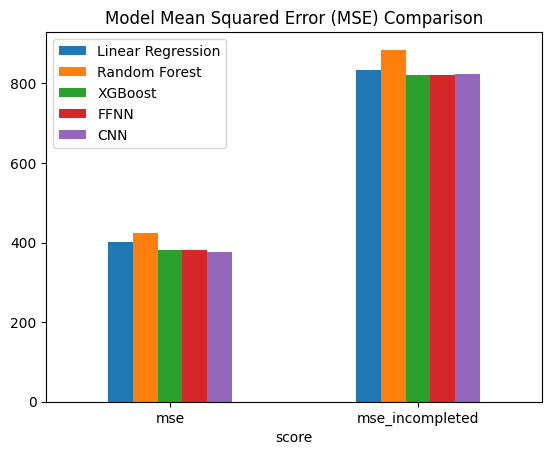

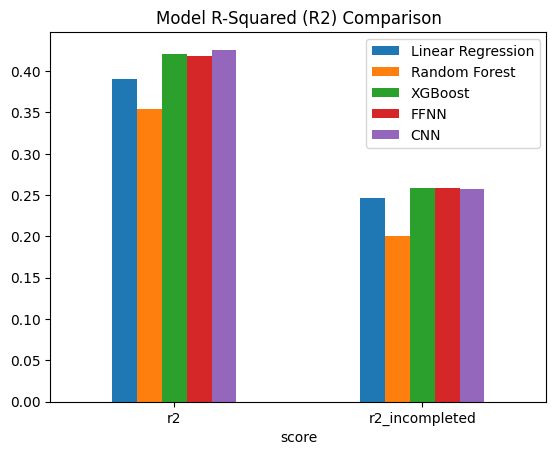

In [333]:
mse_plot = mse_df.plot(
    x="score",
    kind="bar",
    stacked=False,
    title="Model Mean Squared Error (MSE) Comparison",
)

r2_plot = r2_df.plot(
    x="score", kind="bar", stacked=False, title="Model R-Squared (R2) Comparison"
)

mse_plot.xaxis.set_tick_params(rotation=0)
r2_plot.xaxis.set_tick_params(rotation=0)

# Add best model predictions to Dashboard DataFrame

In [334]:
# Get incompleted NCTIDs to use to merge with Dashboard DataFrame
incompleted_ids = pd.read_csv("../results/incompleted_ids.csv")
incompleted_ids

,nctId,status,studyType,primaryPurpose
0,NCT05499390,ACTIVE_NOT_RECRUITING,INTERVENTIONAL,TREATMENT
1,NCT05441683,RECRUITING,INTERVENTIONAL,TREATMENT
2,NCT05613686,RECRUITING,INTERVENTIONAL,TREATMENT
3,NCT05497843,RECRUITING,INTERVENTIONAL,TREATMENT
4,NCT06157541,RECRUITING,INTERVENTIONAL,TREATMENT
...,...,...,...,...
52164,NCT05883852,RECRUITING,INTERVENTIONAL,TREATMENT
52165,NCT02180724,ACTIVE_NOT_RECRUITING,INTERVENTIONAL,TREATMENT
52166,NCT00487305,ACTIVE_NOT_RECRUITING,INTERVENTIONAL,TREATMENT
52167,NCT05786924,RECRUITING,INTERVENTIONAL,TREATMENT


In [335]:
# Get trial durations for only incompleted studies to find the correct NCTIDs based on y_incomplete values
trial_duration_csv = pd.read_csv("../results/trial_duration.csv")
incompleted_trial_duration_csv = trial_duration_csv[
    trial_duration_csv.nctId.isin(list(incompleted_ids["nctId"]))
]
incompleted_trial_duration_csv.reset_index(inplace=True)
incompleted_trial_duration_csv

,index,nctId,durationMonths
0,132456,NCT05499390,19.533333
1,132457,NCT05441683,25.333333
2,132458,NCT05613686,24.366667
3,132459,NCT05497843,18.266667
4,132460,NCT06157541,26.100000
...,...,...,...
52164,184620,NCT05883852,98.200000
52165,184621,NCT02180724,61.633333
52166,184622,NCT00487305,195.800000
52167,184623,NCT05786924,38.000000


In [336]:
# drop studies that were unable to be embedded and predicted
drop_count = 0
for i, (x, y) in enumerate(
    zip(incompleted_trial_duration_csv["durationMonths"], y_incompleted)
):
    if incompleted_trial_duration_csv.iloc[i]["durationMonths"] != y:
        incompleted_trial_duration_csv = incompleted_trial_duration_csv.drop(i)
        drop_count += 1
incompleted_trial_duration_csv = incompleted_trial_duration_csv.drop("index", axis=1)
incompleted_trial_duration_csv

,nctId,durationMonths
0,NCT05499390,19.533333
1,NCT05441683,25.333333
2,NCT05613686,24.366667
3,NCT05497843,18.266667
4,NCT06157541,26.100000
...,...,...
52164,NCT05883852,98.200000
52165,NCT02180724,61.633333
52166,NCT00487305,195.800000
52167,NCT05786924,38.000000


In [337]:
incompleted_trial_duration_csv["predicted_durationMonths"] = y_pred_incompleted_cnn
incompleted_trial_duration_csv

,nctId,durationMonths,predicted_durationMonths
0,NCT05499390,19.533333,27.747694
1,NCT05441683,25.333333,13.165511
2,NCT05613686,24.366667,19.505198
3,NCT05497843,18.266667,39.157715
4,NCT06157541,26.100000,45.618336
...,...,...,...
52164,NCT05883852,98.200000,48.601349
52165,NCT02180724,61.633333,26.629488
52166,NCT00487305,195.800000,61.075123
52167,NCT05786924,38.000000,50.798630


In [338]:
# Save for use with TrialDuraPredict_Dashboard Jupyter Notebook file
incompleted_trial_duration_csv.to_csv(
    "../results/incompleted_preds_df.csv", index=False
)

# Scoring Predictions

Average fraction of Predicted Trial duration to Current: 0.4013166119377744


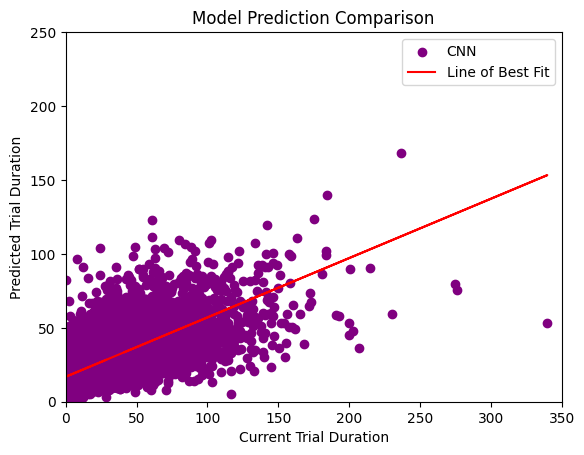

In [339]:
# Reformat array to allow polynomial fitting for line of best fit in graph
y_pred_cnn_list = []
for a in y_pred_cnn:
    y_pred_cnn_list.append(float(a))
y_pred_cnn_list = pd.Series(y_pred_cnn_list)
y_pred_cnn_list


# Plot the results, focusing on the best model


# plt.scatter(y_test, y_pred_lr, label='Linear Regression', color='r')


# plt.scatter(y_test, y_pred_rf, label='Random Forest Regression', color='g')



# plt.scatter(y_test, y_pred_xgb, label='XGBoost', color='b')



# plt.scatter(y_test, y_pred_ffnn, label='FFNN', color='orange')


plt.scatter(y_test, y_pred_cnn, label="CNN", color="purple")


plt.xlabel("Current Trial Duration")


plt.ylabel("Predicted Trial Duration")

m, b = np.polyfit(y_test, y_pred_cnn_list, 1)
plt.plot(y_test, m * y_test + b, color="red", label="Line of Best Fit")
print("Average fraction of Predicted Trial duration to Current:", m)

plt.legend()


plt.title("Model Prediction Comparison")



plt.axis([0, 350, 0, 250])


plt.show()

The slope of line of best fit for the CNN is only 0.401, which means the model generally undervalues the predictions by a fairly large amount even though, if anything, it should overvalue them since these are studies that will continue to go on and have longer durations that currently listed. So we would have hoped to see a slope greater than 1 at least. There are many datapoints on both sides of this line, especially for lower duration trials (<150 months), which may simple be due to a large range of values and many datapoints bringing average down as well as model underperforming.